In [50]:
# Install packages
!pip install -q --upgrade keras-eval stored Pillow==4.0.0 matplotlib

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
import matplotlib
# Set GPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

NameError: name 'os' is not defined

In [3]:
import stored
# Download Test Dataset
stored.sync('https://storage.googleapis.com/sample-datasets/cats-vs-dogs/valid.zip', 'data/valid')

## Evaluator

Easy predictions and evaluations for a single model or an ensemble of many models.

You can add a model directly in the constructor, specifying the `model_path`, you will need to have its `model_spec.json` in the same folder too: 

In [1]:
model_path = 'tmp/fixtures/files/mobilenet_v1/mobilenet_v1.h5'

In [2]:
import keras_eval.eval as eval
from keras.applications import mobilenet
import tensorflow as tf
custom_objects = {'relu6': mobilenet.relu6, 'DepthwiseConv2D': mobilenet.DepthwiseConv2D, "tf": tf}
evaluator = eval.Evaluator(
        data_dir=None,
        custom_objects=custom_objects,
        class_dictionaries=None,
        ensemble_models_dir=None,
        model_path=model_path,
        loss_function='categorical_crossentropy',
        metrics=['accuracy'],
        batch_size=32,
        verbose=0)

/home/albert/.venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


If you forgot to add it, or want to add more, you can do it with this function: 

In [6]:
evaluator.add_model(model_path = 'tmp/fixtures/files/mobilenet_v1/mobilenet_v1.h5')

In [7]:
print('The number of models to evaluate are: ', len(evaluator.models))

The number of models to evaluate are:  2


If you want to remove a model, you just have to specify its index. Let's remove the last added:

In [8]:
evaluator.remove_model(model_index=1)

In [9]:
print('The number of models to evaluate are: ', len(evaluator.models))

The number of models to evaluate are:  1


## Evaluation Functions

### Evaluate a set of images. 

Each sub-folder under `'data_dir/'` will be considered as a different class. E.g. `'data_dir/class_1/dog.jpg'` , `'data_dir/class_2/cat.jpg'`
If you are evaluating an ensemble of models, we currently allow for these probability combination modes: `'maximum'`, `'arithmetic'`, `'geometric'`, `'harmonic'`

**evaluate**

In [10]:
data_dir = 'data/valid/'
probs, labels = evaluator.evaluate(data_dir=data_dir, K=[1], filter_indices=None, confusion_matrix=False, save_confusion_matrix_path=None, combination_mode=None)

print(probs.shape) # [n_models, n_samples, n_classes]
print(labels.shape)# [n_samples, n_classes]

Making predictions from model  0
Input image size:  [224, 224, 3]
Found 2000 images belonging to 2 classes.
63/63 [==============================] - 36s 568ms/step
Accuracy at k=1 is 0.9345
| C_0   | @k=1, sens:0.907 , prec:0.960 |
| C_1   | @k=1, sens:0.962 , prec:0.912 |
(1, 2000, 2)
(2000, 2)


If you want to show a pretty **Confusion Matrix** set `confusion_matrix=True` and you can store it too `save_confusion_matrix_path='cm.png'`

Making predictions from model  0
Input image size:  [224, 224, 3]
Found 2000 images belonging to 2 classes.
63/63 [==============================] - 36s 567ms/step
Accuracy at k=1 is 0.9345
| C_0   | @k=1, sens:0.907 , prec:0.960 |
| C_1   | @k=1, sens:0.962 , prec:0.912 |


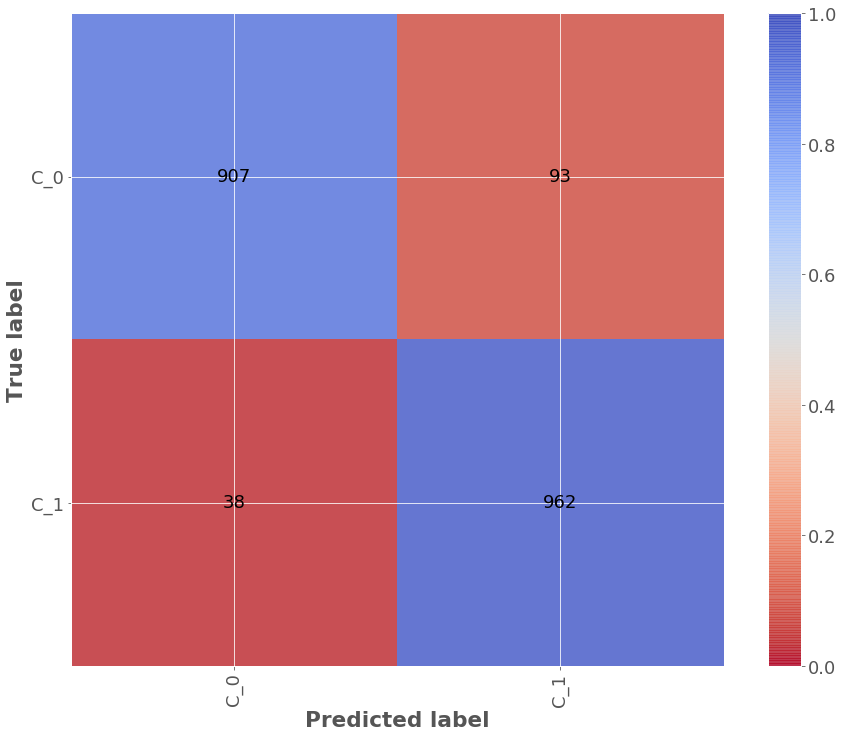

In [41]:
probs, labels = evaluator.evaluate(data_dir=data_dir, confusion_matrix=True, save_confusion_matrix_path='cm.png')

These were the labels by default, but you can set custom names for your classes!

In [34]:
class_dict = [{'abbrev': 'cat', 'class_name': 'cats'}, {'abbrev': 'dog', 'class_name': 'dogs'}]
evaluator.set_class_dictionaries(class_dict)

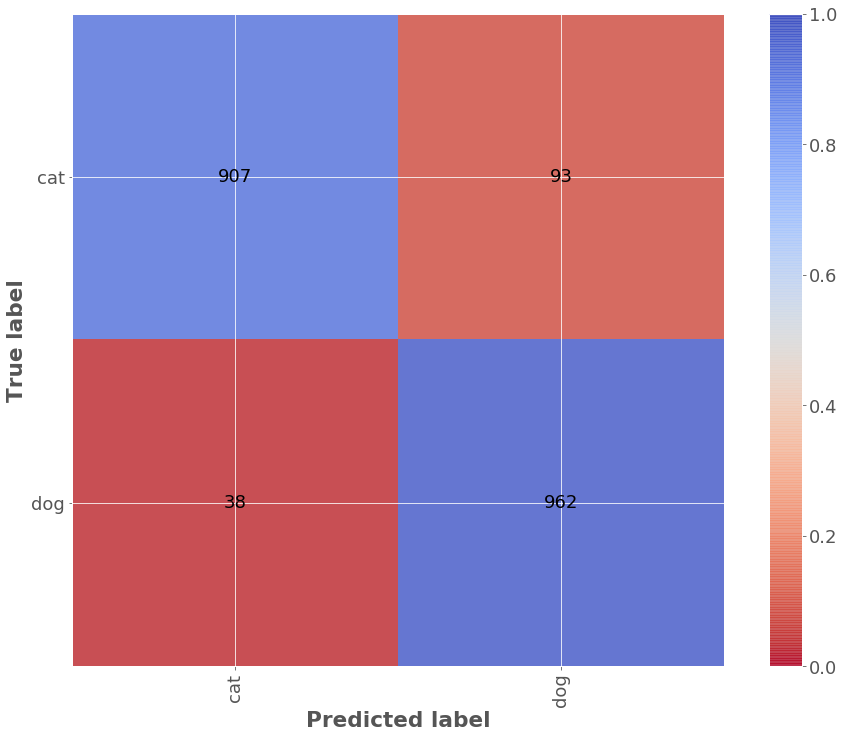

In [37]:
evaluator.plot_confusion_matrix(probs[0], labels=labels)

### Predict class probabilities of a set of images from a folder.

**predict**

In [4]:
folder_path = 'data/valid/cats/'
probs = evaluator.predict(folder_path)

Making predictions from model  0
1000/1000 [==============================] - 18s 18ms/step


You can access to the image paths, see probabilities and plot them

This is what the image looks like: 


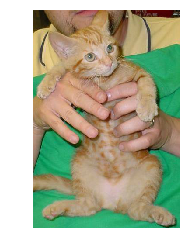

In [11]:
image_0 = evaluator.filenames[0]
plt.imshow(mpimg.imread(image_0))
plt.grid('off')
plt.axis('off')
print('This is what the image looks like: ')

In [10]:
print('These are the probabilities: ', probs[0,0]) # Probabilities of the first image predicted

These are the probabilities:  [0.9769986  0.02300138]


### Predict class probabilities of a single image

**predict**

In [ ]:
image_path = 'data/valid/cats/cat.11878.jpg'
plt.imshow(mpimg.imread(image_path))
plt.grid('off')
plt.axis('off')
print('This is what the image looks like: ')

In [14]:
probs = evaluator.predict(image_path)

Making predictions from model  0
1/1 [==============================] - 0s 50ms/step


In [15]:
for index, c in enumerate(class_dict):
    print('Probability for ' + c['abbrev'] + ' class is %.4f'%probs[0, 0, index])

NameError: name 'class_dict' is not defined